In [44]:
import numpy as np
import cirq
import matplotlib.pyplot as plt
from mezze.tfq import *
import scipy.optimize as spopt

In [20]:
def get_pink_arma(alpha, power=None, wl=.001*np.pi, wh=.999*np.pi):
    """
    Implementes the approach from
    
         S. Plaszczynski, Fluctuation and Noise Letters7, R1 (2007)
     
     ]
    alpha: float between in (0,2] that determines the noise exponent
    power: float to normalize total power
    wl: float normalized frequency cut off for white band at start
    wh: float normalized frequency cut off for 1/f^2 band at end
    
    returns bb, aa np.array of ARMA coefficients (in si.filter form)
    
    """
    Nf = np.ceil(2.5*(np.log10(wh)-np.log10(wl)))
    delp = (np.log10(wh)-np.log10(wl))/Nf
    logps = np.log10(wl)+.5*(1-alpha/2.)*delp + np.arange(Nf)*delp
    logzs = logps+alpha/2.*delp
    ps = 10**(logps)
    zs = 10**(logzs)

    pstx = (1-ps)/(1+ps)
    zstx = (1-zs)/(1+zs)
    bb,aa = si.zpk2tf(zstx,pstx,k=1e-4)
    if power is not None:
        w_pa,h_pa = si.freqz(bb,aa,worN=2048*8, whole=True)
        acv = np.fft.ifft(np.abs(h_pa)**2)
        bb = bb/np.sqrt(acv[0])*np.sqrt(power)
    
    return bb, aa

In [19]:
def makecircg(num_folds,num_trotter,a,B):
    #Creates sensing circuit 
    dt=1 #matches Schwarma conventions 
    q0 = cirq.GridQubit(0,0)
    circ = cirq.Circuit()
    for _ in range(num_trotter):
        circ.append((cirq.X**(0.5/num_trotter)).on(q0))
    for _ in range(num_folds):
        for _ in range(num_trotter):
            circ.append((cirq.X**(0.5/num_trotter)).on(q0))
        for _ in range(num_trotter):
            circ.append((cirq.X**(-0.5/num_trotter)).on(q0)) 
    circ.append((cirq.rz(B*a*dt)).on(q0))
    for _ in range(num_trotter):
        circ.append((cirq.X**(-0.5/num_trotter)).on(q0))
    for _ in range(num_folds):
        for _ in range(num_trotter):
            circ.append((cirq.X**(-0.5/num_trotter)).on(q0))
        for _ in range(num_trotter):
            circ.append((cirq.X**(0.5/num_trotter)).on(q0))
    return circ

In [13]:
def makedumcircg(num_gates,num_trotter): 
    #Creates dummy circuit 
    q0 = cirq.GridQubit(0,0)
    dummy_circ = cirq.Circuit()
    for _ in range(num_gates):
        for _ in range(num_trotter):
            dummy_circ.append((cirq.X**(0.5/num_trotter)).on(q0))
    return dummy_circ

In [14]:
def makenoisecircg(num_folds,num_trotter,angles,a,B):
    #Creates noisy sensing circuit 
    dt=1 #matches Schwarma conventions
    halflength=(len(angles)+2*a)//2 #half length + cut out sensing period 
    q = cirq.GridQubit(0,0)
    circ2 = cirq.Circuit()
    for angle in angles[:num_trotter]:
        circ2.append((cirq.X**((0.5+angle/2)/num_trotter)).on(q))
    for ii in range(num_folds):
        for angle in angles[(2*ii+1)*num_trotter:(2*ii+2)*num_trotter]:
            circ2.append((cirq.X**((0.5+angle/2)/num_trotter)).on(q))
        for angle in angles[(2*ii+2)*num_trotter:(2*ii+3)*num_trotter]:
            circ2.append((cirq.X**(-(0.5-angle/2)/num_trotter)).on(q))
    circ2.append(cirq.rz(B*a*dt).on(q))
    for angle in angles[halflength:halflength+num_trotter]:
        circ2.append((cirq.X**(-(0.5-angle/2)/num_trotter)).on(q))
    for ii in range(num_folds):
        for angle in angles[halflength+(2*ii+1)*num_trotter:halflength+(2*ii+2)*num_trotter]:
            circ2.append((cirq.X**(-(0.5-angle/2)/num_trotter)).on(q))
        for angle in angles[halflength+(2*ii+2)*num_trotter:halflength+(2*ii+3)*num_trotter]:
            circ2.append((cirq.X**((0.5+angle/2)/num_trotter)).on(q))
    return circ2

In [15]:
def ramseyznenum(nfolds,gamma,noisev,a,N_shots,num_trotter): 
    #nfolds: array of foldings 
    #gamma: exponent for color of noise (e.g. 1=1/f noise)
    #noisev: noise strength value
    #a: ratio of sensing time to gate time (e.g. a=100 implies T=100*dt)
    #N_shots: number of shots in simulation 
    #num_trotter: number of trotterization steps of each gate
    numericalresults=[]
    for nfold in nfolds:
    #   make circuits 
        circ=makecircg(nfold,num_trotter,a,B)
        dummy_circ=makedumcircg(2*(2*nfold+1)+a,num_trotter) #dummy circuit for generating noise angles
    #   arma parameters+ops
        bb, aa=get_pink_arma(gamma,((2*noisev/np.pi))**2)
        op_list=[cirq.ops.common_gates.XPowGate,cirq.ops.pauli_gates._PauliX]
    #   schwarmafy 
        S=SingleQubitControlSchWARMAFier(bb,aa,op_list,cirq_gate_multiplicative)
        w,P=S.psd(whole=True) 
        worN=len(w)
        P*=(1/2/num_trotter)**2 #rescale power to account for total number of noisy gates 
    #   getting results
        p1s=[]
        numericalprobs=[] #for a single noisy Ramsey experiment 
        numericalstds=[] #for a single noisy Ramsey experiment 
        #defining noisy circuit 
        for i in range(N_shots):
            #make noisy circuit 
            angles=S.gen_noise_instances(dummy_circ,1)[0]
            circ2=makenoisecircg(nfold,num_trotter,angles,a,B)
            #run simulation  
            sim=cirq.DensityMatrixSimulator()
            result=sim.simulate(circ2)
            p1=result.final_density_matrix[1,1].real
            p1s.append(p1)
        estBTnum=np.arcsin(np.sqrt(np.mean(p1s)))*2 
        numericalresults.append(estBTnum) 
        numericalprobs.append(np.mean(p1s)) #for a single noisy Ramsey experiment
        numericalstds.append(np.std(p1s)/np.sqrt(N_shots)) #for a single noisy Ramsey experiment
    return numericalresults, numericalprobs, numericalstds

In [16]:
def ramseyznean(nfolds,gamma,noisev,a,num_trotter):
    #nfolds: array for total number of foldings 
    #gamma: exponent for color of noise (e.g. 1=1/f noise)
    #noisev: noise strength value
    #a: ratio of sensing time to gate time (e.g. a=100 implies T=100*dt)
    #num_trotter: number of trotterization steps of each gate
    analyticalresults=[]
    for nfold in nfolds:
    #   make circuits 
        circ=makecircg(nfold,num_trotter,a,B)
        dummy_circ=makedumcircg(2*(2*nfold+1)+a,num_trotter)
    #   arma parameters + ops 
        bb, aa=get_pink_arma(gamma,((2*noisev/np.pi))**2)  
        op_list=[cirq.ops.common_gates.XPowGate,cirq.ops.pauli_gates._PauliX]
    #   set up simulation 
        S=SingleQubitControlSchWARMAFier(bb,aa,op_list,cirq_gate_multiplicative)
    #   get noise power spectrum
        w,P=S.psd(whole=True) 
        worN=len(w)
        P*=(1/2/num_trotter)**2 #rescale power to account for total number of noisy gates 
    #   getting results
        Clist=cirq_moments_to_channel_list(circ[0:num_trotter]) #single-gate PTMs
        PTMProp=compute_PTM_prop(Clist)
        FFs=np.fft.fft(PTMProp, n=worN, axis=0) 
        ww=(w-np.pi)*num_trotter #shift frequency to run from -pi to pi
        cotsin=np.array([nfold*2 if w==0 else np.sin(nfold*w*dt)/np.tan(w*dt/2) for w in ww])
        F=np.abs(FFs[:worN,0,0])**2*np.pi**2/4/dt*(np.cos(nfold*ww*dt)+cotsin)**2
        Ft=F*np.cos(ww*((2*nfold+1)*dt+a*dt)) #opposite-side cross-correlation FF  
        chi=np.dot(P,F)/worN #divide by len(w) to normalize by frequency steps
        chit=np.dot(P,Ft)/worN #opposite-side cross-correlation overlap 
        cosBT=np.cos(B*a*dt)
        transprobsan=0.5*(1-(cosBT*np.cosh(4*chit)-np.sinh(4*chit))*np.exp(-4*chi))
        estBTan=np.arcsin(np.sqrt(transprobsan))*2
        analyticalresults.append(estBTan)         
    return analyticalresults

In [17]:
from scipy.optimize import curve_fit

def linfit(x,a,b):
    return a*x + b

Example: 1/f noise 

In [41]:
gamma=1 #noise color 
dt=1  
N_shots=500
noisev=np.pi/10
num_trotter=30
nfolds=np.arange(0,3) 
a=100
Bs=np.arange(0.02,0.52,.04)/a/dt #dividing by a*dt to fix BT
#store values
ramseyerr=[]
numericalerr=[]
analyticalerr=[]
ramseyerrbars=[]
numericalerrbars=[]
for B in Bs:
    #getting results
    numericalresult, numericalprob, numericalstds=ramseyznenum(nfolds,gamma,noisev,a,N_shots,num_trotter)
    analyticalresult=ramseyznean(nfolds,gamma,noisev,a,num_trotter)
    #curve fitting
    paramsnum, cov=curve_fit(linfit,2*(2*nfolds+1),numericalresult)
    paramsan=curve_fit(linfit,2*(2*nfolds+1),analyticalresult)
    perrnum=[np.absolute(cov[i][i])**0.5 for i,_ in enumerate(paramsnum)]
    ramseyerr.append(np.abs(B*a*dt-numericalresult[0]))
    numericalerr.append(np.abs(B*a*dt-paramsnum[1]))
    analyticalerr.append(np.abs(B*a*dt-paramsan[0][1]))
    #error bars
    ramseyerrbars.append(1/2/np.sqrt(numericalprob[0]*(1-numericalprob[0]))*numericalstds[0])
    numericalerrbars.append(perrnum[1])

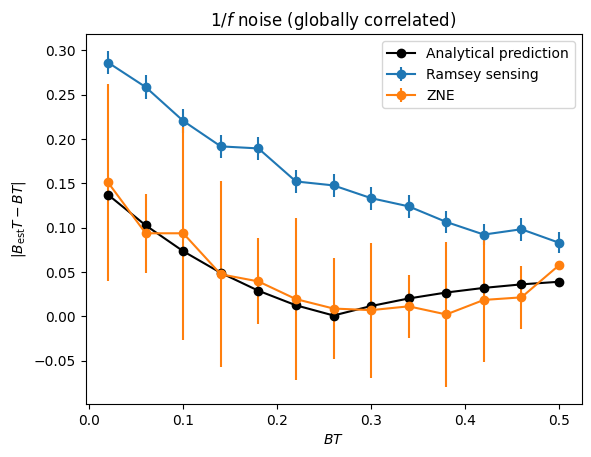

In [42]:
#plot 
fig,ax=plt.subplots()
ax.errorbar(Bs*a*dt,ramseyerr,ramseyerrbars,0,'-o',label='Ramsey sensing')
ax.errorbar(Bs*a*dt,numericalerr,numericalerrbars,0,'-o',label='ZNE')
ax.plot(Bs*a*dt,analyticalerr,'-o',color='black',label='Analytical prediction')
ax.set_xlabel('$BT$')
ax.set_ylabel('$|B_{\mathrm{est}}T-BT|$')
plt.title('white noise (uncorrelated)' if gamma==0 else ('$1/f$ noise (globally correlated)' if gamma==1 else '$1/f^{%d}$ noise (globally correlated)'%gamma))
ax.legend()
plt.show()